Saved predicted Helsinki hex CO2 to helsinki_hex_predicted_car_co2_rf.csv


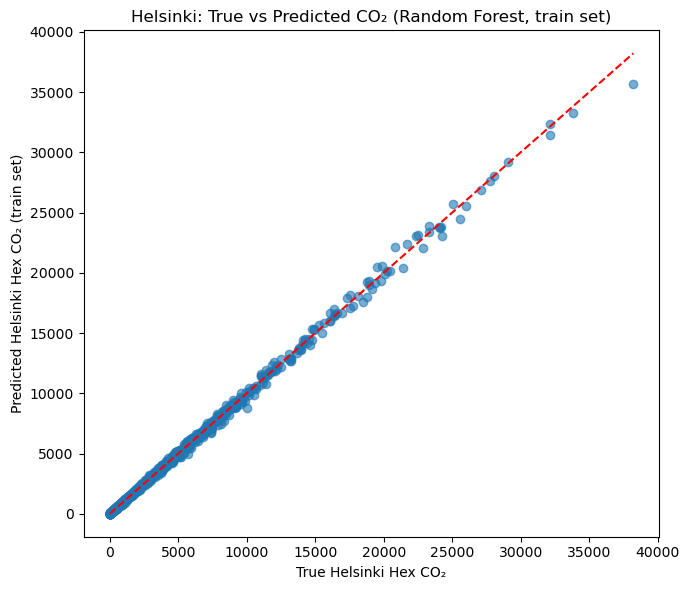


Random Forest feature importances:
total_car_dist      : 0.766
total_shortest_dist : 0.223
population          : 0.003
total_car_time      : 0.002
no_of_trips         : 0.002
avg_speed           : 0.001
total_built_area    : 0.001
stop_count          : 0.000
n_traffic_signals   : 0.000


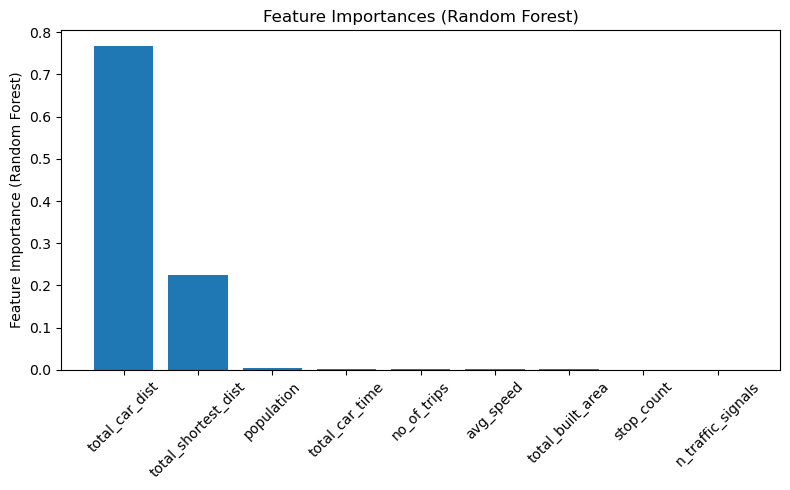


Test set size: 1208
MSE: 262874.9082361289
R^2: 0.9861025140750102


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Load data
df_trip = pd.read_csv("locomizer_data_complete.csv")
df_hex = pd.read_csv("hex_attributes_combined.csv")
df_trip['one'] = 1

# 2. Aggregate only these per origin hexagon
agg_funcs = {
    'car_co2_locomizer': 'sum',
    'car_dist': 'sum',
    'car_time': 'sum',
    'shortest_distance_m': 'sum',
    'one': 'sum'   # total number of trips
}
grouped = (
    df_trip
    .groupby('ORIGIN_CODE9')
    .agg(agg_funcs)
    .rename(columns={
        'car_co2_locomizer': 'total_car_co2',
        'car_dist': 'total_car_dist',
        'car_time': 'total_car_time',
        'shortest_distance_m': 'total_shortest_dist',
        'one': 'no_of_trips'
    })
    .reset_index()
    .rename(columns={'ORIGIN_CODE9': 'hex_id'})
)

# 3. Merge static attributes from df_hex
merged = grouped.merge(df_hex, on='hex_id', how='left')

# 4. Attach municipality info
if 'ORIGIN_Municipality' in df_trip.columns:
    muni = df_trip[['ORIGIN_CODE9', 'ORIGIN_Municipality']].drop_duplicates().rename(
        columns={'ORIGIN_CODE9': 'hex_id'}
    )
    merged = merged.merge(muni, on='hex_id', how='left')

# 5. Split by municipality
train = merged[merged['ORIGIN_Municipality'].str.lower() == 'espoo'].copy()
test = merged[merged['ORIGIN_Municipality'].str.lower() == 'helsinki'].copy()

# 6. Features for ML
features = [
    'population', 'avg_speed', 'n_traffic_signals', 'total_built_area', 'stop_count',
    'total_car_dist', 'total_car_time', 'total_shortest_dist', 'no_of_trips'
]
target = 'total_car_co2'

train = train.dropna(subset=features + [target])
test = test.dropna(subset=features)

X_train = train[features].values
y_train = train[target].values
X_test = test[features].values
y_test = test[target].values

# 7. Train and predict with Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
test['predicted_car_co2'] = y_pred

# 8. Save results
test[['hex_id', 'predicted_car_co2'] + features].to_csv('helsinki_hex_predicted_car_co2_rf.csv', index=False)
print("Saved predicted Helsinki hex CO2 to helsinki_hex_predicted_car_co2_rf.csv")

# 9. Optional: plot true vs predicted for Espoo (train set)
y_train_pred = rf.predict(X_train)
plt.figure(figsize=(7,6))
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.xlabel("True Helsinki Hex CO₂")
plt.ylabel("Predicted Helsinki Hex CO₂ (train set)")
plt.title("Helsinki: True vs Predicted CO₂ (Random Forest, train set)")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.tight_layout()
plt.show()

# 10. Feature importances
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
print("\nRandom Forest feature importances:")
for idx in sorted_idx:
    print(f"{features[idx]:20s}: {importances[idx]:.3f}")

plt.figure(figsize=(8,5))
plt.bar([features[i] for i in sorted_idx], importances[sorted_idx])
plt.xticks(rotation=45)
plt.ylabel("Feature Importance (Random Forest)")
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

# 11. Print test set metrics
print(f"\nTest set size: {len(y_pred)}")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))


In [1]:
import geopandas as gpd
import folium

# Assume: df_helsinki has columns: 'hex_id', 'true_car_co2', 'predicted_car_co2'
#          gdf_hex is your H3 polygons GeoDataFrame with 'hex_id' and 'geometry'

df_helsinki['diff_co2'] = df_helsinki['predicted_car_co2'] - df_helsinki['true_car_co2']

# Merge with geometry
gdf_map = gdf_hex.merge(df_helsinki, on='hex_id')

# Helper to plot one map
def plot_hex_map(gdf, value_col, map_name):
    center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]
    m = folium.Map(location=center, zoom_start=11)
    folium.Choropleth(
        geo_data=gdf,
        data=gdf,
        columns=['hex_id', value_col],
        key_on='feature.properties.hex_id',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=value_col
    ).add_to(m)
    m.save(f"{map_name}.html")
    return m

# Create each map
plot_hex_map(gdf_map, 'true_car_co2', "observed_co2_map")
plot_hex_map(gdf_map, 'predicted_car_co2', "predicted_co2_map")
plot_hex_map(gdf_map, 'diff_co2', "diff_co2_map")


NameError: name 'df_helsinki' is not defined